# Toy example estimation of Radon-Nikodym derivative (one sided)

Equation (5) of the paper by Binkowski et al. explains that the Radon-Nikodym derivative $\frac{d \mathbb{Q}_y}{ \mathbb{P}_y^G}$ of the two domains exist under the assumptions they state. This derivative can also be seen as the ratio between the two distributions of the domains, and can be used to express the compensation for imbalance in the domains:

$\mathbb{E}_{Y \sim \mathbb{Q}_y}[D(Y)] = \mathbb{E}_{X \sim \mathbb{P}_x}[D(G(X)) \frac{d \mathbb{Q}_y}{ d\mathbb{P}_y^G}(G(X))]$

This expresses compensation for imbalance between the discriminator outputs, caused by the imbalance in the domain distributions. However, it does not necessarily have to be used for the imbalance in the discriminator outputs. It can be applied to any imbalance caused by the different domain distributions.

The following toy example shows how we can use the Radon-Nikodym derivative for compensating the imbalance for the mean of the domains using $\mathbb{E}[{Y}] = \mathbb{E}[{X\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}}]$.


Let $X = [1, 1, 1, 1, 1, 1, 1, 0, 0]$, with mean $\bar{X} = 0.8$ and <br />
Let $Y = [1, 1, 0, 0, 0, 0, 0, 0, 0]$, with mean $\bar{Y} = 0.2$

Then $[1, 1, 0, 0, 0, 0, 0, 0, 0] = [1, 1, 1, 1, 1, 1, 1, 0, 0] \cdot \frac{d \mathbb{Q}_y}{d \mathbb{P}_x}(X)$, and <br />
$\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}(X) = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 4, 4]$

This can be interpreted as the ratio between means of the domains for each of the samples. In this example the ratio can be calculated. However, in more complex situations, for example with images, the Radon-Nykodym derivative $\frac{d \mathbb{Q}_y}{d \mathbb{P}_x}$ is unknown and we may try to estimate it using a neural network $W$. This leads to the objective function

$\inf_{W \in \mathcal{W}} (\mathbb{E}_{X \sim \mathbb{P}_x} [D(G(X)) \cdot W(X)] - \mathbb{E}_{Y \sim \mathbb{Q}_y}[D(Y)])^2$

used by Binkowski et al. for compensation of distributions in the domains, using the discriminator output. Similarly, we can use such a network in our toy example.

In this toy example, instead of using the estimated derivative to weight the samples, we use them to sample from the distribution.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch.unsqueeze(1).unsqueeze(1).cpu(), nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0.5)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def binary_data(size=(2**21, 1), ratio=0.5, offset=0.2, std=0):
    
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio

    m = torch.distributions.normal.Normal(torch.Tensor([0]), torch.ones((int(torch.prod(torch.Tensor(size)))))*std)
    
    image_batch = torch.zeros(size) + offset # light color
    image_batch[idx] = 1 - offset # dark color 
    
    image_batch += m.sample().view(size)
    return image_batch.clamp(0, 1).cuda()

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, std=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        std (float): the standard deviation of the noise in the data set
        '''
        self.offset = offset
        self.ratio = ratio
        self.std = std
        
        self.dataset = binary_data(ratio=self.ratio, 
                                         offset=self.offset,
                                         std=self.std)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 1))

        example_imgs[0] += self.offset # light color
        example_imgs[1] = 1 - self.offset # dark color
        return example_imgs

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

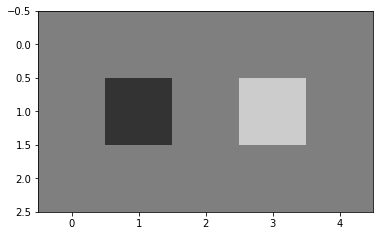

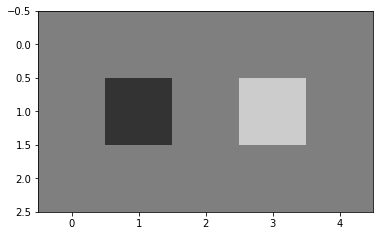

In [5]:
# Settings for domain A (red)
offset_A = 0.2
ratio_A = 0.2
std_A = 0.05
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, std=std_A)
dataloader_A = DataLoader(dataset_A, batch_size=256, shuffle=True)

# Settings for domain B (green)
offset_B = 0.2
ratio_B = 0.8
std_B = 0.05
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, std=std_B)
dataloader_B = DataLoader(dataset_B, batch_size=64, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

torch.Size([256, 1])


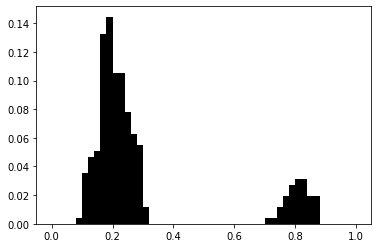

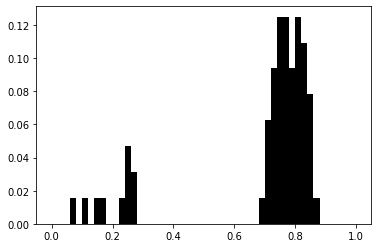

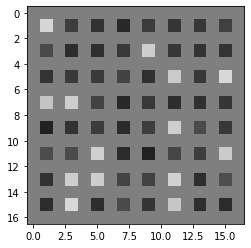

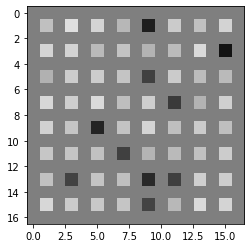

In [6]:
import cv2

def plot_hist(data):
    data = data.squeeze().cpu()
    plt.hist(data, weights=torch.ones(len(data))/len(data), 
             color='black', bins=50, range= (0, 1))
#     plt.gca().set_facecolor('xkcd:gray')
    x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
    print(data_A.shape)
    plot_hist(data_A)
    plot_hist(data_B)
    
    visualize_img_batch(data_A[:64])
    visualize_img_batch(data_B[:64])
    break

In [7]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        self.fc2 = nn.Linear(1, 1)
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x))
        out = self.fc2(h1)
        return self.softmax(out)
#         return out

In [8]:
# Initialize the networks
weight_network = WeightNet().cuda()

# Initialize the optimizers
lr = 0.01
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)

losses_w = []

mean_A = []
mean_B = []

L_As = []
L_Bs = []

example_importances_A = []
example_importances_B = []

sampled_batch_size = 64

def weight_normalization(w):
    return w

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):

        # The weighting process
        w = weight_network(real_A)
        
        sampled_idx_A = list( # Sample from batch A according to these importances
            torch.utils.data.sampler.WeightedRandomSampler(w.squeeze(),
                                                           sampled_batch_size, 
                                                           replacement=False))
        w_sampled = w[sampled_idx_A]
        sampled_A = real_A[sampled_idx_A] # The sampled smaller batch A
        
        # The loss function --------------------------------------------------------------------------------
        
        # Using the means as objective function
        L_A  = (sampled_A * (w_sampled/w_sampled.detach())).sum()
        L_B = (real_B).sum()
        loss_w = (L_A - L_B)**2
        
        mean_A += [sampled_A.mean()]
        mean_B += [real_B.mean()]

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step()   

        # Store values --------------------------------------------------------------------------------------
        L_As += [L_A.item()]
        L_Bs += [L_B.item()]
        
        losses_w += [loss_w.item()]
        
        w_a = weight_normalization((weight_network(dataset_A.example_imgs.view(-1,1).cuda())))
        example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            print('step', i, 'loss_w: ', loss_w.item())
            
        if i % 5000 == 0 and i != 0:
            break

step 0 loss_w:  387.8427429199219
step 500 loss_w:  20.171077728271484
step 1000 loss_w:  0.0016175159253180027
step 1500 loss_w:  43.313194274902344
step 2000 loss_w:  12.066761016845703
step 2500 loss_w:  12.089405059814453
step 3000 loss_w:  1.449208378791809
step 3500 loss_w:  3.551809549331665
step 4000 loss_w:  34.62835693359375
step 4500 loss_w:  5.1038689613342285
step 5000 loss_w:  8.661972045898438


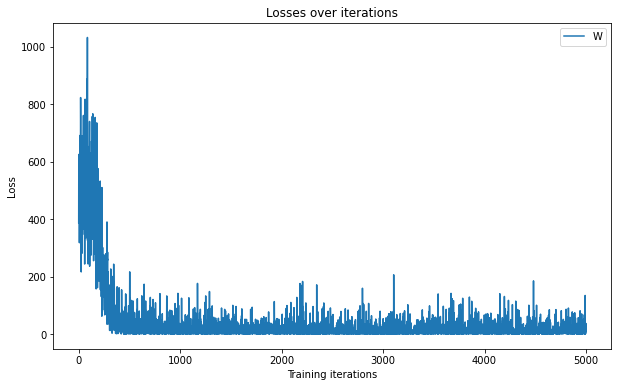

In [9]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_w)
plt.legend(['W'])
plt.show()

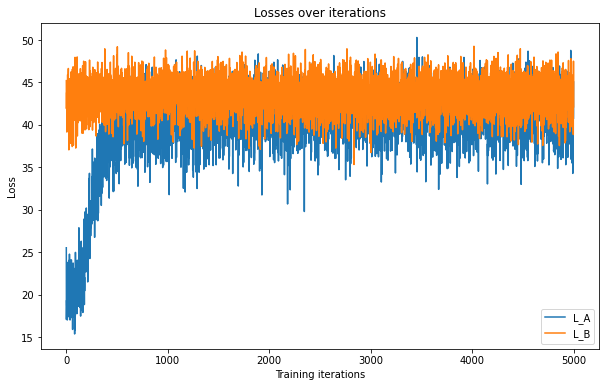

In [10]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(L_As)
plt.plot(L_Bs)
plt.legend(['L_A', 'L_B'])
plt.show()

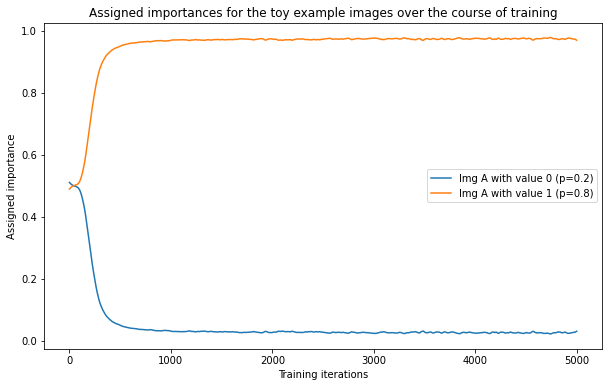

(0.03069353848695755, 0.969306468963623)

In [11]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.legend(['Img A with value {} (p={})'.format(0, ratio_A), 
            'Img A with value {} (p={})'.format(1, 1-ratio_A)])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()

example_importances_A[-1]

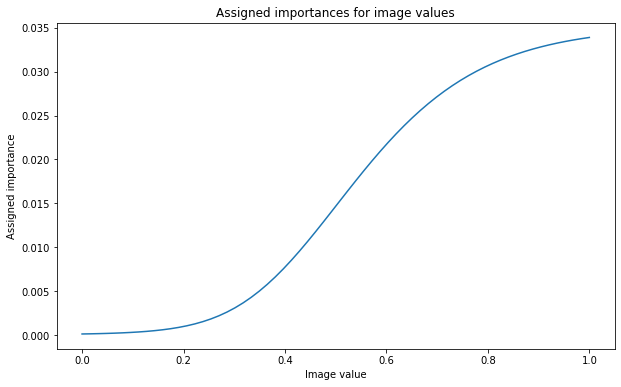

In [12]:
weights = weight_network(torch.linspace(0, 1, 64).view(-1,1).cuda()).cpu().detach().numpy()
plt.figure(figsize=(10,6))
plt.title('Assigned importances for image values')
plt.plot(torch.linspace(0, 1, 64), weights)
plt.ylabel('Assigned importance')
plt.xlabel('Image value')
plt.show()

In [13]:
a = example_importances_A[-1][0]
b = example_importances_A[-1][1]
a, b

(0.03069353848695755, 0.969306468963623)

In [14]:
a/b, ratio_A**2/ratio_B**2

(0.031665463369675954, 0.0625)

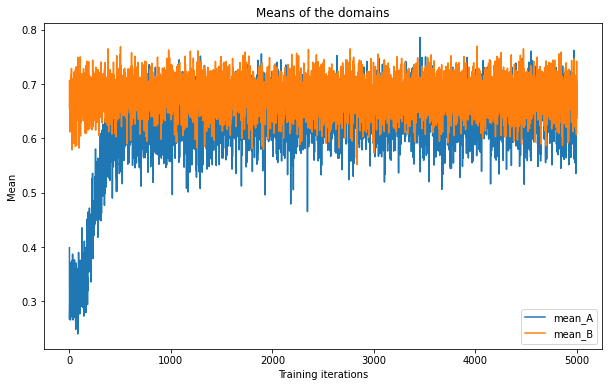

In [15]:
plt.figure(figsize=(10,6))
plt.title('Means of the domains')
plt.xlabel('Training iterations')
plt.ylabel('Mean')
plt.plot(mean_A)
plt.plot(mean_B)
plt.legend(['mean_A', 'mean_B'])
plt.show()